# Publication-quality plots with `matplotlib`

To create good, informative graphics for scientific publications is a very broad and complex topic. My experience is that many authors of scientific articles obviously invest a lot of time on the text but seem to have spent only very little time to create, finetune or homogenise their figures. The graphics often seem to be close to the first output of whatever the authors plotting software shows them. The graphics of all plotting programs in their default configurations are optimised to show reasonable results *on the screen*. However, this does not lead to good results within a publication document. In fact, graphics that are optimised for a written document do not make a good first impression *on the screen*  - see also below. 

In this notebook, we show a possibility to configure `matplotlib` to obtain high-quality figures for publications based on LaTeX-typesetting. Our procedures also allow us to easily adapt existing `matplotlib` plotting scripts - often by just adding two additional lines of `python`-code!

## Goals of this notebook
Our goal is to generate homogeneous and aesthetic graphics that can easily be linked with the main text of a scientific publication. We note that this is *only one* aspect of figure-generation that typically happens at the very end of the process. We will not cover other aspects of graphics genration in this document (such as *how to choose the right type of figure to present your data* or *how and when to use colors*).

## What typically happens

In the following we show the usual process to generate scientific graphics and to integrate them into a LaTeX-document. The following cells perform a simple fit to a set of data from the [COBE satellite](http://lambda.gsfc.nasa.gov/product/cobe/) and plot the result:

In [1]:
# required modules
%matplotlib inline
import sys
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as so

# append path to find the module 'homogenise_plot'
sys.path.append('./code')

In [2]:
# Fit a Planck function to COBE data:

# The function to be minimised:
def planck(f, A0, T):
    return A0 * f**3 / (np.exp(1.439 * f / T)-1.0)

# read in the data; note that loadtxt automatically
# skips lines starting with '#' (comments)
data = np.loadtxt("./data/Cobe.txt")

freq = data[:,0]
spectrum = data[:,1]
# note that the error is in kJ / sr and the
# spectrum in MJ/sr!
spectrum_err = (data[:,2] / 1000.)

popt, pcov = so.curve_fit(planck, freq, spectrum,
                          sigma=spectrum_err, absolute_sigma=True)

# print result
print("Temperature of the universe: %8.6f+/-%8.6f K"
       % (popt[1], np.sqrt(pcov[1,1])))

Temperature of the universe: 2.725431+/-0.000030 K


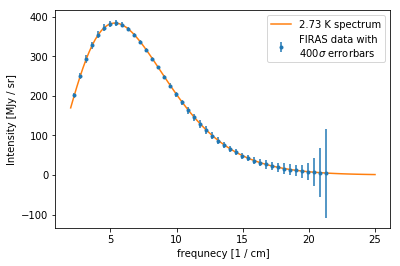

In [3]:
# plot the data and the result of the fit:
f = np.linspace(2.0, 25.0, 100)
s = planck(f, *popt)

plt.errorbar(freq, spectrum, fmt='.', yerr=spectrum_err * 400,
             label='FIRAS data with' "\n" r'$400\sigma$ errorbars')
plt.plot(f, s, label="2.73 K spectrum")

plt.xlabel("frequnecy [1 / cm]")
plt.ylabel("Intensity [MJy / sr]")

plt.legend()
# save the figure to a file and also show it:
plt.savefig("./figs/cobe.png")
plt.show()

We note that the graphics looks reasonable *on the screen*! The obtained plot is now integrated into a LaTeX-document with commands such as
```latex
\begin{figure}
  \centering
  \includegraphics[width=\columnwidth]{cobe}
  \caption{Scaled down of the originial matplotlib plot.
    Usually, the text looks very small.}
  \label{fig:image1}
\end{figure}
```
Note that we typically need to scale down the plot (`width=\columnwidth`) to make it fit on a LaTeX-document page or column.
We imported the plot into a simple LaTeX-document ([sample_document_first.tex](./LaTeX/sample_document_first.tex)) whose PDF-output is available [here](./pdf/my_sample_document_first.pdf).

The essential part of the output file looks like:

<img src="figs/sample_document_first_cropped.png" style="width: 600px;">

At this stage we realise that the font sizes of labels and legends do not match well with the main text. Usually, the plot is now regenerated with modified line thicknesses, label sizes etc. It is reintegrated in our document and this iterative process is continued until the result *looks good*.

## Automatically homogenising and beautifying a plot

We developed a module [homegenise_plot](./code/homogenise_plot.py) which only needs to be included in a plotting script before the actual plotting takes place. It takes care of necessary config parameters to create homogeneous plots which link well with the main text of a LaTeX-document. We first demonstrate its usage with the example above and discuss further details below:

The following cell is *identical* to the plotting cell above with the following modifications:
- the module `homogenise_plot` is imported and initialised for a figure width of 2.8 inch
(columnwidth within a two-column document). This is the columnwidth of the LaTeX-style we use for our example. Scientific articles typically have a columnwidth of 3.5 inch which is used when this parameter is omitted.
- physical units in the labels are typeset with the LaTeX `siunitx` package. This is discussed further below.

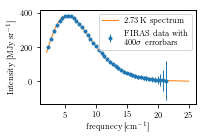

In [5]:
# plot the data and the result of the fit:
import homogenise_plot as hp

# create a homogenised plot for a columnwidth of 2.8 inch:
hp.homogenise_plot(fig_width=2.8)

f = np.linspace(2.0, 25.0, 100)
s = planck(f, *popt)

# note in the following that we typeset units with the LaTeX
# siunitx-package. This is enabled within the 'homogenise_plot'
# function
plt.errorbar(freq, spectrum, fmt='.', yerr=spectrum_err * 400,
             label='FIRAS data with' "\n" r'$400\sigma$ errorbars')
plt.plot(f, s, label=r"\SI{2.73}{\kelvin} spectrum")

plt.xlabel(r"frequnecy [\si{\per\centi\meter}]")
plt.ylabel(r"Intensity [\si{\mega\jansky\per\steradian}]")

plt.legend()
# save the figure to a file and also show it:
plt.savefig("./figs/cobe_homogenise.png")
plt.show()

# revert changes to the configuration made by homogenize_plot:
hp.revert_params()

We first note that the plot looks *much too small* on the screen. However, it is in exactly the correct size that no more scaling is necessary when we include this plot into our LaTeX-document! Graphics created in this way should be included with lines as:
```latex
\begin{figure}
  \centering
  % do NOT specify any scaling!!
  \includegraphics{cobe_homogenise}
  \caption{The new plot has the correct size and the
  font sizes well match the main text!}
  \label{fig:image2}
\end{figure}
```
The result of importing both figure versions into the LaTeX-document [sample_document_second.tex](./LaTeX/sample_document_second.tex) is in this 
[PDF-document](./pdf/my_sample_document_second.pdf); see also the follwing figure:

<img src="figs/sample_document_second_cropped.png" style="width: 600px;">

## What it does and how it works

### What the current version of the `homogenise_plot` module does
We describe here the settings chosen for the current version of the module. Of course, you might have other preferences or different needs for some configuration parameters. We show below, how you can adapt the module to your own needs. The main concern is that you end up with a set of *homogeneous* graphics for your publication.

Integrating the module `homogenise_plot` into a plotting script influences `matplotlib` configuration as follows:
1. We specify *a fixed size* for the graphics so that *it does not need any scaling* when being imported into a LaTeX-document.

Specifying the correct dimensions for a graphic at the creation stage is essential to integrate a figure well with the main text. When specifying fixed font sizes, line widths etc., they *only* appear with the configured values if the graphic *is not rescaled* later!

In my reasearch area (astronomy), most articles are published in a two-column text format, where each column has a width of 3.5 inch ($\approx$ 90 mm). Graphics are inlined with the main text in a figure width of one column or they are *stand-alone* occupying the full pagewidth of $\approx$ 7 inch.

Concerning the figure size, the module can be initialised as follows:
```
import homogenise_plot as hp

# create a plot with a width of 3.5 inch
# (one column-plot)
hp.homogenise_plot()

# create a plot with a width of 7 inch
# (two column plot)
hp.homogenise_plot(columns=2)

# explicitely specify figure width:
# (here for 2.8 inch)
hp.homogenise_plot(fig_width=2.8)

# explicitely specify width and height:
# (both are 2.8 inch)
hp.homogenise_plot(fig_width=2.8, fig_height=2.8)
```
In all cases, when the figure height is not explicitely specified (the first three options), it is fixed to:
$$
\frac{\text{fig_height}}{\text{fig_width}} = \frac{\sqrt{5} - 1}{2}.
$$
This *golden ratio* of figure height and figure width generally leads to very good and aesthetic results. Of course it is sometimes necessary to have a quadratic plot etc.

**Note:** If you need to find out the actual columnwidth of your LaTeX document-style, you can follow for instance [this link](https://tex.stackexchange.com/questions/378178/how-to-know-the-column-width-of-a-two-column-article).

2. The fonts for all plot elements (labels, titles, legends etc.) are set to a common size of 8 points. This gives good results for a document with a main-text font-size of 10 points. You can change this size by specifying it when initialising the module:

```
import homogenise_plot as hp

# use a fontsize of 10 points instead of 8 points
hp.homogenise_plot(fontsize=10)
```

3. We enable the possibility to typeset numbers and units with the LaTeX `siunitx`-package. We note that you need LaTeX to be installed on your computer to use this feature. Please see [this document](./pdf/siunitx.pdf) if you do not yet know the `siunitx` package or if you would like to learn more on the issues and problems to typeset numbers and units correctly in LaTeX.

We note that LaTeX is integrated into `matplotlib` and you should use it for all mathemtical expressions within your plot! Within a plot, style conventions for typesetting mathematical expressions apply as they do for the main text. Because most plotting tools do not directly support LaTeX or switching between fonts in a plot is cumbersome, this rule is ignored by most authors.

A technical remark is that LaTeX-expressions need to be realised in Python source code with *raw strings*. This ensures that the backslash character `\` is not interpreted for *escape characters* by the Python interprester but is passed to the LaTeX-compiler - see next cell.

In [ ]:
# demonstration of raw strings

# \n represents newline
normal_string = "Thomas \n Erben"
print('normal string: ', normal_string)

# a raw string (inidicated by an 'r' before the quotation mark)
# is not touched by the Python interpreter
raw_string = r"Thomas \n Erben"
print('raw string: ', raw_string)

4. Other settings concern the choice of a *serif font* and a graphic resolution of 300 dots per inch when the graphic is exported in a bitmap graphics format (e.g. `png`).

### Adapting the module to your own needs
You can easily adapt the module to your own needs. We show the source code in a cell below and it should be clear, where you need to adapt parameters if you want to. Please check [the documentaion on customizing matplotlib](https://matplotlib.org/users/customizing.html) to learn more about the (endless) possibilities to influence `matplotlib`-configuration.

Please check whether the current settings satisfy your needs before using the module. Some points that might be considered:

- You should consult the authors instructions and/or style-guide of your journal and adapt the module with their requirements or recommendations.

- The module is optimised for publications in scientific journals. They should be adapted for other applications such as slide-talks, PR-quality plots or large posters.

In [ ]:
import matplotlib
import numpy as np

# store original plot parameters so that we can revert:
ORIG_MATPLOTLIB_CONF = dict(matplotlib.rcParams)

def homogenise_plot(fig_width=None, fig_height=None, columns=1, fontsize=8):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this function before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}; 1 is default
    fontsze : 8 pt default
    """

    assert(columns in [1,2])

    if fig_width is None:
        # figure widths for one-column and two-column printing
        # (taken from https://www.elsevier.com/authors/author-schemas/artwork-and-media-instructions/artwork-sizing)
        if columns == 2:
            fig_width = 7
        else:
            fig_width = 3.5

    if fig_height is None:
        golden_ratio = (np.sqrt(5.0) - 1.0) / 2.0    # Aesthetic ratio
        fig_height = fig_width * golden_ratio # height in inches

    params = {'backend': 'ps',
              'text.latex.preamble':
              [ r'\usepackage{siunitx}',
                r'\usepackage[utf8]{inputenc}',
                r'\usepackage[T1]{fontenc}',
                r'\DeclareSIUnit \jansky {Jy}' ],
              'axes.labelsize' : fontsize,
              'axes.titlesize' : fontsize,
              'font.size': fontsize,
              'legend.fontsize' : fontsize,
              'xtick.labelsize' : fontsize,
              'ytick.labelsize' : fontsize,
              'axes.linewidth' : 1,
              'lines.linewidth' : 1,
              'text.usetex' : True,
              'figure.figsize' : [fig_width, fig_height],
              'font.family' : 'serif',
              'savefig.bbox' : 'tight',
              'savefig.dpi' : 300  # set to 600 for poster printing or PR
                                  # figures
    }

    matplotlib.rcParams.update(params)

def revert_params():
    """
    reverts any changes done to matplotlib parameters and restores
    the state before homogenize_plot was called
    """

    matplotlib.rcParams.update(ORIG_MATPLOTLIB_CONF)


## Software versions
Here are the Python and module versions I used to create this notebook

In [1]:
%reload_ext version_information
%version_information numpy, scipy, matplotlib

Software versions
Python 3.6.8 64bit [GCC 7.3.0]
IPython 7.4.0
OS Linux 3.13.0 165 generic x86_64 with debian jessie sid
numpy 1.16.1
scipy 1.2.1
matplotlib 3.0.3
Mon May 06 00:57:09 2019 CEST